In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import numpy as np
import re
%matplotlib inline
plt.style.use('ggplot') 

# Fundamental Data

In [2]:
# Create a database connection
user = 'postgres'
host = 'localhost'
dbname = 'mimic'
schema = 'mimiciii'

In [3]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password:········


We follow the paper 

Predicting Mortality in Diabetic ICU Patients Using Machine Learning and Severity Indices: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961793/

In [4]:
# Get feature according to the paper

query = \
"""
with icd as
(
  select hadm_id, subject_id
    , cast(icd9_code as char(5)) as icd9_code
  from diagnoses_icd
)
, db_patience as
(select icd.hadm_id,icd.subject_id
from icd
where icd9_code between '2500 ' and '2599 '
or icd9_code between '2400 ' and '2499 '
or icd9_code = '3572 '
or icd9_code = '3620 '
or icd9_code = '36641'
or icd9_code = '6484 '
group by 1,2
)
,lab_aggs as
(
select le.hadm_id
, min(case when itemid in (50852,50854) then le.valuenum else null end) as HbA1c_min
, max(case when itemid in (50852,50854) then le.valuenum else null end) as HbA1c_max
, avg(case when itemid in (50852,50854) then le.valuenum else null end) as HbA1c_mean
, min(case when itemid in (50931) then le.valuenum else null end) as lab_glucose_min
, max(case when itemid in (50931) then le.valuenum else null end) as lab_glucose_max
, avg(case when itemid in (50931) then le.valuenum else null end) as lab_glucose_mean
, min(case when itemid in (50912) then le.valuenum else null end) as serum_creatinine_min
, max(case when itemid in (50912) then le.valuenum else null end) as serum_creatinine_max
, avg(case when itemid in (50912) then le.valuenum else null end) as serum_creatinine_mean
from labevents le 
where itemid in
(50852,50854,50931,50912
)
group by 1

)





select dbp.hadm_id,dbp.subject_id, ad.admittime, ad.dischtime, ad.deathtime
, ie.first_careunit, ie.last_careunit
, extract(epoch from (ad.admittime - p.dob))/60.0/60.0/24.0/365.242 as age
, p.gender as gender
, ad.marital_status as marital_status
, ad.admission_type
, ad.ethnicity
, ad.insurance as insurance
,HbA1c_min
,HbA1c_max
,HbA1c_mean
,lab_glucose_min
,lab_glucose_max
,lab_glucose_mean
,la.serum_creatinine_min
,la.serum_creatinine_max
,la.serum_creatinine_mean


from db_patience dbp
inner join lab_aggs la
on dbp.hadm_id = la.hadm_id
inner join patients p
on dbp.subject_id = p.subject_id
inner join admissions ad
on la.hadm_id = ad.hadm_id
inner join icustays ie
on la.hadm_id = ie.hadm_id
where  HbA1c_max is not null
and lab_glucose_mean is not null

group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
order by 1,2


;
"""

data = pd.read_sql_query(query,con)
print(data.shape)
data.head()

(3401, 22)


,hadm_id,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,marital_status,...,insurance,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean
0,100009,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,60.797126,M,MARRIED,...,Private,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333
1,100059,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,68.266622,M,MARRIED,...,Medicare,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818
2,100065,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,59.223624,M,MARRIED,...,Private,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333
3,100068,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,74.319627,F,WIDOWED,...,Medicare,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692
4,100094,82593,2109-06-06 10:21:00,2109-06-07 17:00:00,NaT,CCU,CCU,57.746456,F,MARRIED,...,Private,5.5,5.5,5.5,88.0,113.0,100.500000,0.9,0.9,0.900000


In [5]:
# Assign Death label from the availability of deathtime
data['Death'] = (~ np.isnat(data['deathtime'])).astype(int)
data.head()

,hadm_id,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,marital_status,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100009,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,60.797126,M,MARRIED,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,100059,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,68.266622,M,MARRIED,...,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,100065,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,59.223624,M,MARRIED,...,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,100068,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,74.319627,F,WIDOWED,...,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,100094,82593,2109-06-06 10:21:00,2109-06-07 17:00:00,NaT,CCU,CCU,57.746456,F,MARRIED,...,5.5,5.5,5.5,88.0,113.0,100.500000,0.9,0.9,0.900000,0


In [6]:
# number of alive and death subject
data['Death'].value_counts()

0    3189
1     212
Name: Death, dtype: int64

# Diabetes complications severity index (DCSI) 

In [7]:
# Gain data from diagnoses_icd to create DCSI score

In [8]:
query = \
"""
SELECT di.hadm_id,di.subject_id, di.ICD9_CODE
FROM diagnoses_icd di;
"""

diag = pd.read_sql_query(query,con)

In [9]:
diag.head()

,hadm_id,subject_id,icd9_code
0,172335,109,40301
1,172335,109,486
2,172335,109,58281
3,172335,109,5855
4,172335,109,4254


In [10]:
diag.shape

(651047, 3)

In [11]:
#Using eliminate hadm_id in diagnosis dataset that is not in our diabetic data. 
diag = diag[diag['hadm_id'].isin(data['hadm_id'])];

In [12]:
diag.head()

,hadm_id,subject_id,icd9_code
110,195632,123,41011
111,195632,123,41401
112,195632,123,4019
113,195632,123,25000
114,195632,123,3051


In [13]:
diag = diag[diag['icd9_code'].notnull()]

In [14]:
diag.shape

(45198, 3)

Create DCSI severity score according to the paper Diabetes complications severity index and risk of mortality, hospitalization, and healthcare utilization. https://www.ncbi.nlm.nih.gov/pubmed/18197741

In [15]:
def severity_score(df):
    
    data = np.asarray(df['icd9_code']);
    scores = np.zeros([7]);
    try:
        for item in data:

            if re.match(r'^2505[0-9]$',item) or  re.match(r'^36201$',item) or  re.match(r'^3621$',item) or  re.match(r'^36283$',item) or  re.match(r'^336253$',item) or  re.match(r'^36281$',item) or  re.match(r'^36282$',item) :
                scores[0]=max(scores[0],1);
            elif re.match(r'^36202$',item) or  re.match(r'^361[0-9][0-9]$',item) or  re.match(r'^369[0-9][0-9]$',item) or  re.match(r'^37923$',item):
                scores[0]=max(scores[0],2);
            elif re.match(r'^2504$',item) or  re.match(r'^580$',item) or  re.match(r'^581$',item) or  re.match(r'^58181$',item) or  re.match(r'^582$',item) or  re.match(r'^583$',item) :
                scores[1]=max(scores[1],1);
            elif re.match(r'^585$',item) or  re.match(r'^586$',item) or  re.match(r'^5939$',item):
                scores[1]=max(scores[1],2);
            else:
                pattern3 = [r'^3569$',r'^2506$',r'^3581$',r'^9510$',r'^9511$',r'^9513$',r'^35[4-5][0-9]$',r'^7135$',r'^3572$',r'^59654$',r'^337[0-1]$',r'^5645$',r'^5363$',r'^4580$'];
                for p in pattern3:
                    if(re.match(p,item)):
                        scores[2]=max(scores[2],1);
            if re.match(r'^435$',item):
                scores[3]=max(scores[3],1);
            elif  re.match(r'^43[1,3,4,6]$',item):
                scores[3]=max(scores[3],2);
            elif re.match(r'^440[0-9][0-9]$',item) or  re.match(r'^41[1,3,4]$',item) or  re.match(r'^4292$',item):
                scores[4]=max(scores[4],1);
            elif re.match(r'^410$',item) or re.match(r'^427[1,3]$',item) or re.match(r'^427[4,5]$',item)or re.match(r'^412$',item)or re.match(r'^428$',item)or re.match(r'^4402[3,4]$',item)or re.match(r'^441$',item):
                scores[4]=max(scores[4],2);
            elif  re.match(r'^2507$',item) or re.match(r'^4423$',item) or re.match(r'^44381$',item) or re.match(r'^4439$',item) or re.match(r'^8921$',item):
                scores[5]=max(scores[5],1);
            elif  re.match(r'^44422$',item) or re.match(r'^7854$',item) or re.match(r'^040$',item) or re.match(r'^7071$',item):
                scores[5]=max(scores[5],2);
            elif  re.match(r'^250[1,2,3]$',item):
                scores[6]=max(scores[6],2);

        total_score = np.sum(scores)-scores[1];
    except:
        print(item)
            
    return [scores[1],np.sum(scores)]


dcsi_score=diag.groupby(['hadm_id']).apply(severity_score)

In [16]:
# Create dataframe from series 
# The output will be the sum of 1,3-7 categories and the score for 2 category which need serum measurement to make
# the calculation complete
dcsi_score = pd.DataFrame({'hadm_id':dcsi_score.index, 'score':dcsi_score.values})
print(dcsi_score.shape)
dcsi_score.head()

(3244, 2)


,hadm_id,score
0,100009,"[0.0, 1.0]"
1,100059,"[0.0, 0.0]"
2,100065,"[0.0, 0.0]"
3,100068,"[0.0, 2.0]"
4,100094,"[0.0, 0.0]"


In [17]:
# Create serum measurement data set
serum_df = data[['hadm_id','serum_creatinine_mean']]
serum_df.head()

,hadm_id,serum_creatinine_mean
0,100009,0.783333
1,100059,0.881818
2,100065,1.308333
3,100068,4.307692
4,100094,0.900000


In [18]:
serum_df.shape

(3401, 2)

In [19]:
# merge the dcsi score and serum dataframe
dcsi_score = pd.merge(dcsi_score, serum_df, how='inner', on=['hadm_id'])
dcsi_score.head()

,hadm_id,score,serum_creatinine_mean
0,100009,"[0.0, 1.0]",0.783333
1,100059,"[0.0, 0.0]",0.881818
2,100065,"[0.0, 0.0]",1.308333
3,100068,"[0.0, 2.0]",4.307692
4,100094,"[0.0, 0.0]",0.900000


In [20]:
# Calculate the final score

def final_severity_score(df):
    
    score = np.asarray(df['score']);
    serum =df['serum_creatinine_mean'];
    if(serum>=2):
        add = 2;
    elif (serum>=1.5):
        add = 1;
    else:
        add =0;
        
    df['DCSI'] = score[1]+add
    return df

dcsi_score = dcsi_score.apply(final_severity_score,axis=1)
dcsi_score.head(20)

,hadm_id,score,serum_creatinine_mean,DCSI
0,100009,"[0.0, 1.0]",0.783333,1.0
1,100059,"[0.0, 0.0]",0.881818,0.0
2,100065,"[0.0, 0.0]",1.308333,0.0
3,100068,"[0.0, 2.0]",4.307692,4.0
4,100094,"[0.0, 0.0]",0.900000,0.0
5,100114,"[0.0, 1.0]",2.825000,3.0
6,100138,"[0.0, 0.0]",0.694872,0.0
7,100139,"[0.0, 2.0]",5.950000,4.0
8,100166,"[0.0, 1.0]",0.588889,1.0
9,100173,"[0.0, 0.0]",0.477778,0.0


In [21]:
dcsi_score = dcsi_score[['hadm_id','DCSI']]

In [22]:
dcsi_score['hadm_id'].value_counts

<bound method IndexOpsMixin.value_counts of 0       100009
1       100059
2       100065
3       100068
4       100094
         ...  
3396    199961
3397    199963
3398    199967
3399    199979
3400    199981
Name: hadm_id, Length: 3401, dtype: int64>

In [23]:
# Join the dcsi and diabetic data
#join_dcsi = pd.merge(dcsi_score, data, how='inner', on=['hadm_id'])
join_dcsi = pd.merge(dcsi_score, data, how='left', on=['hadm_id'])

In [24]:
join_dcsi['DCSI'].value_counts()

0.0    1685
2.0     859
1.0     559
3.0     290
4.0     210
5.0      76
6.0      30
7.0      10
8.0       2
Name: DCSI, dtype: int64

In [25]:
join_dcsi.shape

(3721, 24)

In [26]:
join_dcsi = join_dcsi.drop_duplicates()

In [27]:
join_dcsi.shape

(3401, 24)

In [28]:
join_dcsi

,hadm_id,DCSI,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100009,1.0,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,60.797126,M,...,7.9,7.9,7.900,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,100059,0.0,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,68.266622,M,...,7.1,7.1,7.100,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,100065,0.0,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,59.223624,M,...,13.7,13.7,13.700,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,100068,4.0,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,74.319627,F,...,7.0,7.0,7.000,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,100094,0.0,82593,2109-06-06 10:21:00,2109-06-07 17:00:00,NaT,CCU,CCU,57.746456,F,...,5.5,5.5,5.500,88.0,113.0,100.500000,0.9,0.9,0.900000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,199961,2.0,20620,2115-06-29 00:03:00,2115-07-12 13:50:00,NaT,SICU,SICU,58.462614,M,...,7.1,7.1,7.100,66.0,209.0,132.800000,3.2,4.1,3.545455,0
3717,199963,2.0,5478,2101-08-23 16:43:00,2101-09-08 13:30:00,NaT,CCU,CCU,70.467516,M,...,6.0,6.3,6.125,66.0,217.0,125.600000,2.0,4.1,3.237931,0
3718,199967,0.0,42131,2184-07-31 16:22:00,2184-08-10 12:15:00,NaT,SICU,SICU,82.577255,F,...,5.8,5.8,5.800,94.0,122.0,106.454545,0.6,0.8,0.681818,0
3719,199979,0.0,41115,2182-02-05 03:30:00,2182-02-10 14:50:00,NaT,CSRU,CSRU,79.470997,M,...,5.7,5.7,5.700,101.0,160.0,132.250000,0.7,1.0,0.800000,0


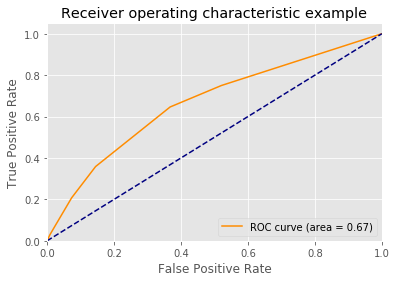

In [29]:
y_test = np.asarray(join_dcsi['Death']);
y_score= np.asarray(join_dcsi['DCSI']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ELIXHAUSER SCORE


We use SQL relation (ELIXHAUSER_QUAN_SCORE) created using SQL code from https://github.com/MIT-LCP/mimic-code

In [30]:
query = \
"""
SELECT *
FROM ELIXHAUSER_QUAN_SCORE;
"""

eli = pd.read_sql_query(query,con)



In [31]:
eli.head()

,hadm_id,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30
0,100001,5.0,5.0,6.0
1,100003,11.0,4.0,5.0
2,100006,11.0,11.0,22.0
3,100007,0.0,-1.0,-2.0
4,100009,-2.0,-2.0,5.0


In [32]:
join_eli = pd.merge(eli, data, how='inner', on=['hadm_id'])
join_eli.head()

,hadm_id,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100009,-2.0,-2.0,5.0,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,100059,0.0,-2.0,-2.0,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,...,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,100065,0.0,-1.0,-2.0,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,...,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,100068,14.0,18.0,27.0,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,...,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,100094,0.0,-1.0,-2.0,82593,2109-06-06 10:21:00,2109-06-07 17:00:00,NaT,CCU,CCU,...,5.5,5.5,5.5,88.0,113.0,100.500000,0.9,0.9,0.900000,0


## There are 3 type of elixhauser score, we then test all and choose the best score.

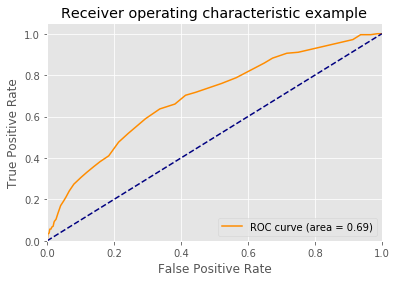

In [33]:
# Using elixhauser_vanwalraven

join_eli_vanwalraven= join_eli[['Death','elixhauser_vanwalraven']];
join_eli_vanwalraven=join_eli_vanwalraven.dropna()

y_test = np.asarray(join_eli_vanwalraven['Death']);
y_score= np.asarray(join_eli_vanwalraven['elixhauser_vanwalraven']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

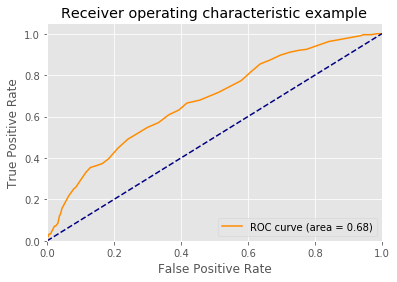

In [34]:
# Using elixhauser_29

join_eli_29= join_eli[['Death','elixhauser_sid29']];
join_eli_29=join_eli_29.dropna()

y_test = np.asarray(join_eli_29['Death']);
y_score= np.asarray(join_eli_29['elixhauser_sid29']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

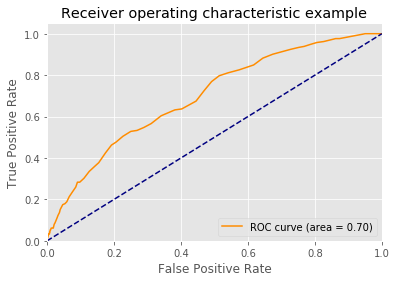

In [35]:
# Using elixhauser_30

join_eli_30= join_eli[['Death','elixhauser_sid30']];
join_eli_30=join_eli_30.dropna()

y_test = np.asarray(join_eli_30['Death']);
y_score= np.asarray(join_eli_30['elixhauser_sid30']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Charlson comorbidity score (CCS)

We follow the proceduce in R code from https://cran.r-project.org/web/packages/comorbidity/vignettes/comorbidityscores.html to create the CCS score

## Using SQL query to create CCS category

In [36]:
query = \
"""

with
icd as
(
  select hadm_id, seq_num
    , cast(icd9_code as char(5)) as icd9_code
  from diagnoses_icd
)
,
eliflg as
(
select hadm_id, seq_num, icd9_code
-- note that these codes will seem incomplete at first
-- for example, CHF is missing a lot of codes referenced in the literature (402.11, 402.91, etc)
-- these codes are captured by hypertension flags instead
-- later there are some complicated rules which confirm/reject those codes as CHF
, CASE
  when icd9_code between '4100 ' and '4109 ' then 1
  when icd9_code between '4120 ' and '4129 ' then 1
    end as MI /* Myocardial infarction */      
, case
    when icd9_code = '39891' then 1
    when icd9_code = '40201' then 1
    when icd9_code = '40211' then 1
    when icd9_code = '40291' then 1
    when icd9_code = '40401' then 1
    when icd9_code = '40403' then 1
    when icd9_code = '40411' then 1
    when icd9_code = '40413' then 1
    when icd9_code = '40491' then 1
    when icd9_code = '40493' then 1
    when icd9_code between '4254 ' and '4259 ' then 1
    when icd9_code between '4280 ' and '4299 ' then 1
  end as CHF /* Congestive heart failure */

, CASE
    when icd9_code = '0930 ' then 1
    when icd9_code = '4373 ' then 1
    when icd9_code between '4400 ' and '4409 ' then 1
    when icd9_code between '4410 ' and '4419 ' then 1
    when icd9_code between '4431 ' and '4439 ' then 1
    when icd9_code = '4471 ' then 1
    when icd9_code = '5571 ' then 1
    when icd9_code = '5579 ' then 1
    when icd9_code = 'V434 ' then 1

end as PVD    /* Peripheral vascular disease */

, CASE
  when icd9_code = '36234' then 1
  when icd9_code between '4300 ' and '4389 ' then 1
end as CD  /* Cerebrovascular disease */

, CASE
  when icd9_code between '2900 ' and '2909 ' then 1
  when icd9_code = '2941 ' then 1
  when icd9_code = '3312 ' then 1
end as DT  /* Dementia */

, CASE
  when icd9_code = '4168 ' then 1
  when icd9_code = '4169 ' then 1
  when icd9_code between '4900 ' and '5059 ' then 1
  when icd9_code = '5064 ' then 1
  when icd9_code = '5081 ' then 1
  when icd9_code = '5088 ' then 1
end as CPD       /* Chronic pulmonary disease */

, CASE
  when icd9_code = '4465 ' then 1
  when icd9_code between '7100 ' and '7104 ' then 1
  when icd9_code between '7140 ' and '7142 ' then 1
  when icd9_code = '7148 ' then 1
  when icd9_code between '7250 ' and '7259 ' then 1
end as RHD     /* Rheumatic disease */


, CASE
  when icd9_code between '5310 ' and '5349 ' then 1
end as PUD   /* Peptic ulcer disease */

, CASE
  when icd9_code = '07022' then 1
  when icd9_code = '07023' then 1
  when icd9_code = '07032' then 1
  when icd9_code = '07033' then 1
  when icd9_code = '07044' then 1
  when icd9_code = '07054' then 1
  when icd9_code = '0706 ' then 1
  when icd9_code between '5700 ' and '5709 ' then 1
  when icd9_code between '5710 ' and '5719 ' then 1
  when icd9_code = '5733 ' then 1
  when icd9_code = '5734 ' then 1
  when icd9_code = '5738 ' then 1
  when icd9_code = '5739 ' then 1
  when icd9_code = 'V427' then 1
end as MLD  /* Mild liver disease */

, CASE
  when icd9_code between '2500 ' and '2503 ' then 1
  when icd9_code = '2508 ' then 1
  when icd9_code = '2509 ' then 1
end as DWOCC   /* Diabetes without chronic complication */

, CASE
  when icd9_code between '2504 ' and '2507 ' then 1
end as DWCC   /* Diabetes with chronic complication */



, CASE
  when icd9_code = '3341 ' then 1
  when icd9_code between '3420 ' and '3429 ' then 1
  when icd9_code between '3430 ' and '3439 ' then 1
  when icd9_code between '3440 ' and '3446 ' then 1
  when icd9_code = '3449 ' then 1
end as HOP  /* Hemiplegia or paraplegia */

, CASE
  when icd9_code = '40301' then 1
  when icd9_code = '40311' then 1
  when icd9_code = '40391' then 1
  when icd9_code = '40402' then 1
  when icd9_code = '40403' then 1
  when icd9_code = '40412' then 1
  when icd9_code = '40413' then 1
  when icd9_code = '40492' then 1
  when icd9_code = '40493' then 1
  when icd9_code between '5820 ' and '5829 ' then 1
  when icd9_code between '5830 ' and '5837 ' then 1
  when icd9_code between '5850 ' and '5859 ' then 1
  when icd9_code between '5860 ' and '5869 ' then 1
  when icd9_code = '5880 ' then 1
  when icd9_code = 'V420 ' then 1
  when icd9_code = 'V451 ' then 1
  when icd9_code between 'V560 ' and 'V569 ' then 1
end as RD   /* Renal disease */

, CASE
  when icd9_code between '1400 ' and '1729 ' then 1
  when icd9_code between '1740 ' and '1958 ' then 1
  when icd9_code between '2000 ' and '2089 ' then 1
  when icd9_code = '2386 ' then 1
end as AM  /* Any malignancy, including lymphoma and leukaemia, except malignant neoplasm of skin */

, CASE
  when icd9_code between '4560 ' and '4562 ' then 1
  when icd9_code between '5722 ' and '5728 ' then 1
end as MOSLD   /* Moderate or severe liver disease */

, CASE
  when icd9_code between '1960 ' and '1999 ' then 1
end as MST    /* Metastatic solid tumour */

, CASE
  when icd9_code between '0420 ' and '0449 ' then 1
end as HIV   /* AIDS/HIV */


from icd
)
-- collapse the icd9_code specific flags into hadm_id specific flags
-- this groups comorbidities together for a single patient admission
, eligrp as
(
  select hadm_id
  , max(MI) as MI
  , max(CHF) as CHF
  , max(PVD) as PVD
  , max(CD) as CD
  , max(DT) as DT
  , max(CPD) as CPD
  , max(RHD) as RHD
  , max(PUD) as PUD
  , max(MLD) as MLD
  , max(DWOCC) as DWOCC
  , max(DWCC) as DWCC
  , max(HOP) as HOP
  , max(RD) as RD
  , max(AM) as AM
  , max(MOSLD) as MOSLD
  , max(MST) as MST
  , max(HIV) as HIV

from eliflg
group by hadm_id
)
-- now merge these flags together to define elixhauser
-- most are straightforward.. but hypertension flags are a bit more complicated
select adm.subject_id, adm.hadm_id
, case when MI = 1 then 1 else 0 end as MI
, case when CHF = 1 then 1 else 0 end as CHF
, case when PVD = 1 then 1 else 0 end as PVD
, case when CD = 1 then 1 else 0 end as CD
, case when DT = 1 then 1 else 0 end as DT
, case when CPD = 1 then 1 else 0 end as CPD
, case when RHD = 1 then 1 else 0 end as RHD
, case when PUD = 1 then 1 else 0 end as PUD
, case when MLD = 1 then 1 else 0 end as MLD
, case when DWOCC = 1 then 1 else 0 end as DWOCC
, case when DWCC = 1 then 1 else 0 end as DWCC
, case when HOP = 1 then 1 else 0 end as HOP
, case when RD = 1 then 1 else 0 end as RD
, case when AM = 1 then 1 else 0 end as AM
, case when MOSLD = 1 then 1 else 0 end as MOSLD
, case when MST = 1 then 1 else 0 end as MST
, case when HIV = 1 then 1 else 0 end as HIV


from admissions adm
left join eligrp eli
  on adm.hadm_id = eli.hadm_id
order by adm.hadm_id;

"""

ccs = pd.read_sql_query(query,con)
ccs.head()

,subject_id,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,mld,dwocc,dwcc,hop,rd,am,mosld,mst,hiv
0,58526,100001,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
1,54610,100003,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,9895,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,23018,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,533,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Definition of each column
MI /* Myocardial infarction */ 

CHF /* Congestive heart failure */

PVD    /* Peripheral vascular disease */

CD  /* Cerebrovascular disease */

DT  /* Dementia */

CPD       /* Chronic pulmonary disease */

RHD     /* Rheumatic disease */

PUD   /* Peptic ulcer disease */

MLD  /* Mild liver disease */

DWOCC   /* Diabetes without chronic complication */

DWCC   /* Diabetes with chronic complication */

HOP  /* Hemiplegia or paraplegia */

RD   /* Renal disease */

AM  /* Any malignancy, including lymphoma and leukaemia, except malignant neoplasm of skin */

MOSLD   /* Moderate or severe liver disease */

MST    /* Metastatic solid tumour */

HIV   /* AIDS/HIV */


In [37]:
# create the CCS score
def CCS_score(df):
    score = 0 ;
    score = score + df['mi']+df['chf']+df['pvd']+df['cd']+df['dt']+df['cpd']+df['rhd']+df['mld']+df['dwocc'];
    score = score + 2*(df['dwcc']+df['hop']+df['rd']+df['am'])
    score = score + 3*(df['mosld'])
    score = score + 6*(df['mst']+df['hiv'])

    
    return score

ccs['CCS'] = ccs.apply(CCS_score, axis=1)

In [38]:
ccs.head()

,subject_id,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,mld,dwocc,dwcc,hop,rd,am,mosld,mst,hiv,CCS
0,58526,100001,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,5
1,54610,100003,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
2,9895,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3
3,23018,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,533,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2


In [39]:
join_ccs = pd.merge(ccs, data, how='inner', on=['hadm_id'])
join_ccs.head()

,subject_id_x,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,533,100009,0,0,1,0,0,0,0,0,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,20777,100059,0,0,0,0,0,0,0,0,...,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,27892,100065,0,0,0,0,0,0,0,0,...,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,9889,100068,1,1,1,0,0,0,0,0,...,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,82593,100094,0,0,0,0,0,0,0,0,...,5.5,5.5,5.5,88.0,113.0,100.500000,0.9,0.9,0.900000,0


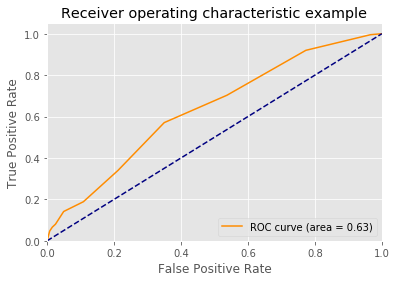

In [40]:
# Using ccs

y_test = np.asarray(join_ccs['Death']);
y_score= np.asarray(join_ccs['CCS']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Join all

In [41]:
eli_30 = eli[['hadm_id','elixhauser_sid30']];

In [42]:
dcsi_score.count()

hadm_id    3401
DCSI       3401
dtype: int64

In [43]:
data.count()

hadm_id                  3401
subject_id               3401
admittime                3401
dischtime                3401
deathtime                 212
first_careunit           3401
last_careunit            3401
age                      3401
gender                   3401
marital_status           3298
admission_type           3401
ethnicity                3401
insurance                3401
hba1c_min                3401
hba1c_max                3401
hba1c_mean               3401
lab_glucose_min          3401
lab_glucose_max          3401
lab_glucose_mean         3401
serum_creatinine_min     3401
serum_creatinine_max     3401
serum_creatinine_mean    3401
Death                    3401
dtype: int64

In [44]:
data_drop = data.drop(['subject_id','admittime','dischtime','first_careunit','last_careunit','deathtime',], axis=1)

In [45]:
data_drop = data_drop.drop(['hba1c_min','hba1c_max','lab_glucose_min','lab_glucose_max','serum_creatinine_min','serum_creatinine_max',], axis=1)

In [46]:
dulplicate =  data_drop[data_drop.duplicated(['hadm_id'])]
dulplicate 

,hadm_id,age,gender,marital_status,admission_type,ethnicity,insurance,hba1c_mean,lab_glucose_mean,serum_creatinine_mean,Death
19,100458,60.214972,F,DIVORCED,EMERGENCY,UNKNOWN/NOT SPECIFIED,Private,6.00,116.333333,0.695238,1
22,100606,68.225660,M,MARRIED,EMERGENCY,WHITE,Medicare,5.90,126.923077,1.257143,0
39,101114,59.398516,F,MARRIED,EMERGENCY,WHITE,Private,6.50,183.272727,3.450000,0
40,101114,59.398516,F,MARRIED,EMERGENCY,WHITE,Private,6.50,183.272727,3.450000,0
50,101350,66.683296,M,MARRIED,EMERGENCY,UNKNOWN/NOT SPECIFIED,Private,6.40,135.814815,1.048148,0
...,...,...,...,...,...,...,...,...,...,...,...
3250,195209,45.748346,M,SINGLE,EMERGENCY,MULTI RACE ETHNICITY,Medicaid,8.15,134.894737,1.679167,0
3271,195745,74.966040,M,MARRIED,EMERGENCY,UNABLE TO OBTAIN,Medicare,5.90,133.000000,1.048387,0
3307,196981,82.004971,F,MARRIED,EMERGENCY,WHITE,Medicare,6.30,164.240000,1.623077,0
3310,197044,82.539488,M,SINGLE,EMERGENCY,WHITE,Medicare,11.20,159.761905,0.466667,0


In [47]:
no_data = data_drop.drop_duplicates()

In [48]:
no_data.shape

(3244, 11)

In [49]:
print(data_drop['Death'].value_counts())
join_dcsi = pd.merge(dcsi_score, data_drop, how='inner', on=['hadm_id'])
join_dcsi = join_dcsi.drop_duplicates()
print(join_dcsi['Death'].value_counts())
eli_30 = eli[['hadm_id','elixhauser_sid30']];
join_eli = pd.merge(eli_30, join_dcsi, how='inner', on=['hadm_id'])
print(join_eli['Death'].value_counts())
ccs_score = ccs[['hadm_id','CCS']];
join_total = pd.merge(ccs_score, join_eli, how='inner', on=['hadm_id'])
print(join_total['Death'].value_counts())
join_total = join_total.drop('hadm_id', axis=1)


0    3189
1     212
Name: Death, dtype: int64
0    3052
1     192
Name: Death, dtype: int64
0    3052
1     192
Name: Death, dtype: int64
0    3052
1     192
Name: Death, dtype: int64


In [50]:
join_total.count()

CCS                      3244
elixhauser_sid30         3242
DCSI                     3244
age                      3244
gender                   3244
marital_status           3151
admission_type           3244
ethnicity                3244
insurance                3244
hba1c_mean               3244
lab_glucose_mean         3244
serum_creatinine_mean    3244
Death                    3244
dtype: int64

In [51]:
join_total.columns

Index(['CCS', 'elixhauser_sid30', 'DCSI', 'age', 'gender', 'marital_status',
       'admission_type', 'ethnicity', 'insurance', 'hba1c_mean',
       'lab_glucose_mean', 'serum_creatinine_mean', 'Death'],
      dtype='object')

In [52]:
#join_total = join_total.drop(['subject_id','admittime','dischtime','first_careunit','last_careunit','deathtime'], axis=1)

In [53]:
join_total.columns

Index(['CCS', 'elixhauser_sid30', 'DCSI', 'age', 'gender', 'marital_status',
       'admission_type', 'ethnicity', 'insurance', 'hba1c_mean',
       'lab_glucose_mean', 'serum_creatinine_mean', 'Death'],
      dtype='object')

In [54]:
join_total.dtypes

CCS                        int64
elixhauser_sid30         float64
DCSI                     float64
age                      float64
gender                    object
marital_status            object
admission_type            object
ethnicity                 object
insurance                 object
hba1c_mean               float64
lab_glucose_mean         float64
serum_creatinine_mean    float64
Death                      int64
dtype: object

In [55]:
cat_columns = join_total.select_dtypes(['object']).columns
cat_columns

Index(['gender', 'marital_status', 'admission_type', 'ethnicity', 'insurance'], dtype='object')

In [56]:
join_total[cat_columns] = join_total[cat_columns].apply(lambda x: x.astype('category').cat.codes)


In [57]:
join_total.head(30)

,CCS,elixhauser_sid30,DCSI,age,gender,marital_status,admission_type,ethnicity,insurance,hba1c_mean,lab_glucose_mean,serum_creatinine_mean,Death
0,2,5.0,1.0,60.797126,1,1,1,29,3,7.9,198.800000,0.783333,0
1,1,-2.0,0.0,68.266622,1,1,1,29,2,7.1,140.000000,0.881818,0
2,1,-2.0,0.0,59.223624,1,1,1,7,3,13.7,229.250000,1.308333,0
3,7,27.0,4.0,74.319627,0,5,1,7,2,7.0,190.923077,4.307692,0
4,0,-2.0,0.0,57.746456,0,1,1,28,3,5.5,100.500000,0.900000,0
5,4,5.0,3.0,50.630486,1,1,1,29,2,11.0,176.083333,2.825000,0
6,0,17.0,0.0,54.514579,1,3,1,23,3,5.1,103.000000,0.694872,0
7,4,9.0,4.0,61.720273,1,1,1,29,2,5.9,113.800000,5.950000,0
8,4,19.0,1.0,77.055215,0,1,1,29,2,6.6,115.285714,0.588889,0
9,1,0.0,0.0,41.517686,0,1,1,29,3,12.0,116.666667,0.477778,0


In [58]:

#join_total[cat_columns] = join_total[cat_columns].apply(lambda x: x.cat.codes)
join_total.dtypes

CCS                        int64
elixhauser_sid30         float64
DCSI                     float64
age                      float64
gender                      int8
marital_status              int8
admission_type              int8
ethnicity                   int8
insurance                   int8
hba1c_mean               float64
lab_glucose_mean         float64
serum_creatinine_mean    float64
Death                      int64
dtype: object

In [59]:
join_total.isnull().sum()

CCS                      0
elixhauser_sid30         2
DCSI                     0
age                      0
gender                   0
marital_status           0
admission_type           0
ethnicity                0
insurance                0
hba1c_mean               0
lab_glucose_mean         0
serum_creatinine_mean    0
Death                    0
dtype: int64

In [60]:
X = join_total.drop('Death', axis=1).values

In [61]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
X_filled =  imputer.fit_transform(X)

In [62]:
join_total['Death'].count()

3244

In [63]:
X_filled

array([[  2.        ,   5.        ,   1.        , ...,   7.9       ,
        198.8       ,   0.78333333],
       [  1.        ,  -2.        ,   0.        , ...,   7.1       ,
        140.        ,   0.88181818],
       [  1.        ,  -2.        ,   0.        , ...,  13.7       ,
        229.25      ,   1.30833333],
       ...,
       [  3.        ,   6.        ,   0.        , ...,   5.8       ,
        106.45454545,   0.68181818],
       [  1.        ,  17.        ,   0.        , ...,   5.7       ,
        132.25      ,   0.8       ],
       [  5.        ,  17.        ,   2.        , ...,   7.6       ,
        156.8       ,   1.28      ]])

In [64]:
X = join_total.dropna().drop('Death', axis=1).values;

y = join_total.dropna()['Death'].values

In [65]:
y.shape

(3242,)

In [66]:
#X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size = 0.20)

In [67]:
from sklearn.datasets import load_boston
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np

In [68]:
import os
import numpy
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [69]:
#performs the logistic regression for the data above
model = LogisticRegression(penalty='l2',solver='liblinear', class_weight = 'balanced')
model.fit(X,y)

#evaluate the model
y_predict = model.predict(X)
confusion_matrix(y,y_predict)

#print calssification report
print(classification_report(y,y_predict))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82      3050
           1       0.13      0.70      0.22       192

    accuracy                           0.71      3242
   macro avg       0.55      0.71      0.52      3242
weighted avg       0.92      0.71      0.79      3242



In [70]:
y_predict

array([0, 0, 0, ..., 0, 0, 1])

In [71]:
model.predict_proba(X)

array([[0.63762604, 0.36237396],
       [0.85340739, 0.14659261],
       [0.94823312, 0.05176688],
       ...,
       [0.74045106, 0.25954894],
       [0.7084606 , 0.2915394 ],
       [0.34958989, 0.65041011]])

In [72]:
model.predict_proba(X)[:,0]

array([0.63762604, 0.85340739, 0.94823312, ..., 0.74045106, 0.7084606 ,
       0.34958989])

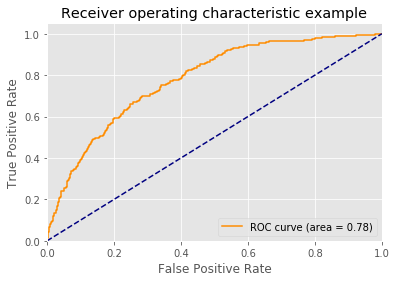

In [73]:
y_test = y;
y_score= model.predict_proba(X)[:,1];
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [74]:
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestClassifier

In [75]:
features1_rf_model = RandomForestClassifier(n_estimators=1000,bootstrap = True,
                               max_features = 'sqrt',class_weight='balanced')
features1_rf_model.fit(X, y)
features1_rf_predictions = features1_rf_model.predict(X)
features1_rf_probs = features1_rf_model.predict_proba(X)[:, 1]


In [76]:
features1_rf_predictions

array([0, 0, 0, ..., 0, 0, 0])

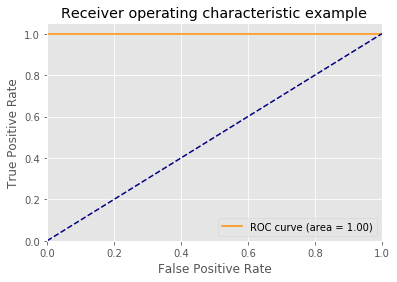

In [77]:
y_test = y;
y_score= features1_rf_probs;
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [78]:
#performs the logistic regression for the data above
modelcv = LogisticRegressionCV(cv=10, random_state=0,penalty='l2',solver='liblinear', class_weight = 'balanced')
modelcv.fit(X,y)

#evaluate the model
y_predict = modelcv.predict(X)
confusion_matrix(y,y_predict)

#print calssification report
print(classification_report(y,y_predict))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      3050
           1       0.13      0.70      0.23       192

    accuracy                           0.72      3242
   macro avg       0.55      0.71      0.53      3242
weighted avg       0.92      0.72      0.79      3242



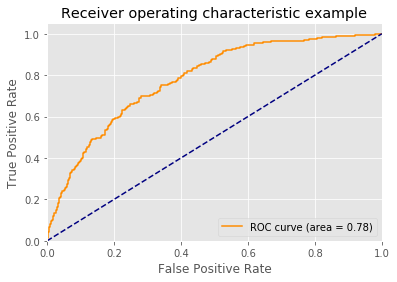

In [79]:
y_test = y;
y_score= modelcv.predict_proba(X)[:,1];
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [80]:
0 - 10 mild 10- 100 avg >100 strong No data

SyntaxError: invalid syntax (<ipython-input-80-d2961266e677>, line 1)

In [81]:
#performs the logistic regression for the data above
model = LogisticRegression(penalty='l2',solver='liblinear', class_weight = 'balanced')
model.fit(X,y)

#evaluate the model
y_predict = model.predict(X)
confusion_matrix(y,y_predict)

#print calssification report
print(classification_report(y,y_predict))No data + mild, avg, strong HbA1

SyntaxError: invalid syntax (<ipython-input-81-cd76d686a4c4>, line 10)

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_validate
logreg=LogisticRegression()
predicted = cross_validate.cross_val_predict(logreg, X, y, cv=10)



/home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


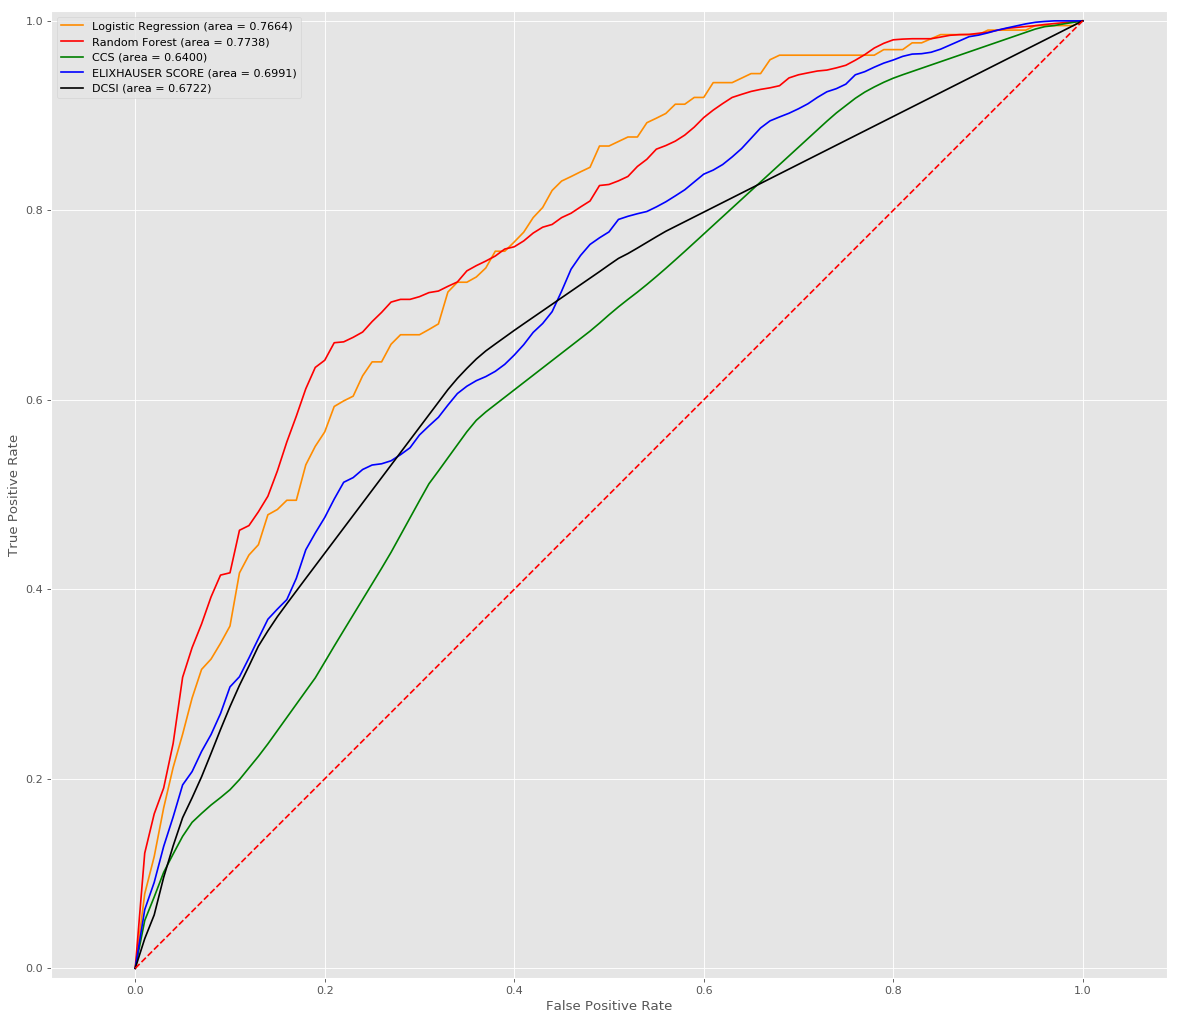

In [82]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
auc_logistic=[];
auc_ccs=[];
auc_eli=[];
auc_dcsi=[];
auc_RF=[];

base_fpr = np.linspace(0, 1, 101)
tprs_logistic = [];
tprs_ccs = [];
tprs_eli = [];
tprs_dcsi = [];
tprs_RF = [];


fpr_avg =[];
tpr_avg =[];

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    
    modelRF = RandomForestClassifier(n_estimators=500,bootstrap = True,
                               max_features = 'sqrt',class_weight='balanced')
    model = LogisticRegression(penalty='l2',solver='liblinear', class_weight = 'balanced')
    model.fit(X_train,y_train)
    modelRF.fit(X_train,y_train)

    #evaluate the model
    y_predict = model.predict_proba(X_test)[:,1]
    y_predictRF = modelRF.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr, tpr)
    auc_logistic.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_logistic.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, y_predictRF)
    roc_auc = auc(fpr, tpr)
    auc_RF.append(roc_auc)
    
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_RF.append(tpr)
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,0])
    roc_auc = auc(fpr, tpr)
    auc_ccs.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_ccs.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_eli.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_eli.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,2])
    roc_auc = auc(fpr, tpr)
    auc_dcsi.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_dcsi.append(tpr)

    
tprs_RF = np.array(tprs_RF)
mean_tprs_RF = tprs_RF.mean(axis=0)
roc_auc_RF = auc(base_fpr, mean_tprs_RF)    
    
    
tprs_logistic = np.array(tprs_logistic)
mean_tprs_logistic = tprs_logistic.mean(axis=0)
roc_auc_logistic = auc(base_fpr, mean_tprs_logistic)

tprs_ccs = np.array(tprs_ccs)
mean_tprs_ccs = tprs_ccs.mean(axis=0)
roc_auc_ccs  = auc(base_fpr, mean_tprs_ccs)

tprs_eli = np.array(tprs_eli)
mean_tprs_eli = tprs_eli.mean(axis=0)
roc_auc_eli  = auc(base_fpr, mean_tprs_eli)

tprs_dcsi = np.array(tprs_dcsi)
mean_tprs_dcsi = tprs_dcsi.mean(axis=0)
roc_auc_dcsi  = auc(base_fpr, mean_tprs_dcsi)


#std = tprs.std(axis=0)

#tprs_upper = np.minimum(mean_tprs + std, 1)
#tprs_lower = mean_tprs - std

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(base_fpr, mean_tprs_logistic, 'darkorange', label='Logistic Regression (area = %0.4f)' % roc_auc_logistic)
plt.plot(base_fpr, mean_tprs_RF, 'r', label='Random Forest (area = %0.4f)' % roc_auc_RF)

plt.plot(base_fpr, mean_tprs_ccs, 'g', label='CCS (area = %0.4f)' % roc_auc_ccs)
plt.plot(base_fpr, mean_tprs_eli, 'b', label='ELIXHAUSER SCORE (area = %0.4f)' % roc_auc_eli)
plt.plot(base_fpr, mean_tprs_dcsi, 'k', label='DCSI (area = %0.4f)' % roc_auc_dcsi)
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.legend()
plt.show()


In [83]:
np.mean(auc_logistic)

0.766332764943106

In [84]:
np.mean(auc_ccs)

0.6401183122202868

In [85]:
np.mean(auc_eli)

0.6990966068692333

In [86]:
np.mean(auc_dcsi)

0.6722775158338117

/home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


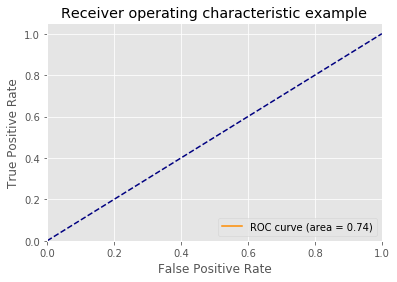

In [87]:

fpr = np.mean(fpr_avg)
tpr = np.mean(tpr_avg)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [88]:
fpr = np.mean(fpr_avg)

In [89]:
fpr_avg

[]

In [90]:
X_test.shape

(324, 12)

In [91]:
X_test[0,:]

array([  4.        ,  34.        ,   3.        ,  81.52328913,
         1.        ,   1.        ,   1.        ,  29.        ,
         2.        ,   7.1       , 131.11111111,   1.96071429])

In [92]:
X_test[:,0]

array([ 4.,  6.,  3.,  4.,  5.,  7.,  2.,  4.,  0.,  4.,  3.,  1.,  2.,
        3.,  4.,  2.,  2.,  4.,  1.,  1.,  5.,  1.,  1.,  2.,  3.,  2.,
        2.,  1., 10.,  1.,  2.,  5.,  1.,  2.,  2.,  4.,  1.,  6.,  6.,
        2.,  6.,  0.,  3.,  4.,  1.,  0.,  6.,  0.,  6.,  4.,  4.,  5.,
        1.,  4.,  3.,  2.,  5.,  1.,  3.,  4.,  7.,  3.,  1.,  3.,  2.,
        3.,  0.,  2.,  4.,  1.,  1.,  2.,  1.,  2.,  8.,  2.,  3.,  2.,
        4.,  2.,  7.,  4.,  1.,  4.,  2.,  3.,  4.,  5.,  5.,  3.,  6.,
        1.,  7.,  2.,  4.,  2., 10.,  3.,  1.,  3.,  9.,  3.,  2.,  1.,
        3.,  3.,  2.,  5.,  3.,  6.,  1.,  1.,  4.,  4.,  2.,  6.,  6.,
        5.,  9.,  3.,  2.,  3.,  1.,  3.,  3.,  4.,  7.,  6.,  1.,  2.,
        6.,  3.,  2.,  3.,  5.,  3.,  4.,  4.,  1.,  2.,  2.,  6.,  6.,
        4.,  3.,  2.,  2.,  3.,  3.,  3.,  1.,  2.,  1.,  3.,  3.,  3.,
        2.,  4.,  1.,  1.,  4.,  5.,  5.,  2.,  4.,  3.,  4.,  1.,  4.,
        2.,  1.,  2.,  2.,  2.,  9.,  3.,  2.,  2.,  4.,  2.,  1

In [93]:
#https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp

from sklearn.datasets import make_classification
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

X, y = make_classification(n_samples=500, random_state=100, flip_y=0.3)

kf = KFold(n=len(y), n_folds=10)

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))

for i, (train, test) in enumerate(kf):
    model = LogisticRegression().fit(X[train], y[train])
    y_score = model.predict_proba(X[test])
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

ModuleNotFoundError: No module named 'sklearn.cross_validation'